# Funções agregadas para análise de dados
<p><img src = https://arquivo.devmedia.com.br/noticias/documentacao/documentacao_sql-funcoes-de-agregacao_38463.png width = 500> </p>

## Introdução
No módulo anterior, discutimos como usar SQL para preparar conjuntos de dados para análise. Uma vez que os dados estão preparados, o próximo passo é analisá-los. Geralmente, cientistas de dados e profissionais de análise tentarão entender os dados resumindo-os e tentando encontrar padrões de alto nível nos dados. O SQL pode ajudar nessa tarefa principalmente por meio do uso de funções agregadas: funções que recebem linhas como entrada e retornam um número para cada linha. Neste módulo, discutiremos como usar funções agregadas básicas e como derivar estatísticas e outras informações úteis de dados usando funções agregadas com **GROUP BY**. Em seguida, usaremos a cláusula **HAVING** para filtrar agregações e ver como limpar os dados e examinar a qualidade dos dados usando funções de agregação. Por fim, veremos como usar agregados para entender a qualidade dos dados

## Funções agregadas
Com dados, muitas vezes estamos interessados ​​em entender as propriedades de uma coluna ou tabela inteira em vez de apenas ver linhas individuais de dados. Como um exemplo simples, digamos que você esteja se perguntando quantos clientes o ZoomZoom tem. Você pode selecionar todos os dados da tabela e ver quantas linhas foram retiradas, mas seria incrivelmente tedioso fazer isso. Felizmente, existem funções fornecidas pelo SQL que podem ser usadas para fazer cálculos em grandes grupos de linhas. Essas funções são chamadas de funções agregadas. A função agregada recebe uma ou mais colunas com várias linhas e retorna um número com base nessas colunas. Como ilustração, podemos usar a função **COUNT** para contar quantas linhas existem na tabela de **clientes** para descobrir quantos clientes o ZoomZoom possui:

In [28]:
import pandas as pd
import psycopg2 as pg

# Realizando a conexão local no Banco de dados (SQLDA)
connection = pg.connect(user="postgres",
                                  password="admin",
                                  host="127.0.0.1",
                                  port="5432",
                                  database="sqlda")
# Query a ser realizada

sql = """
      SELECT COUNT(customer_id)
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,count
0,50000


A função **COUNT** retornará o número de linhas sem um valor **NULL** na coluna. Como a coluna **customer_id** é uma chave primária e não pode ser **NULL**, a função **COUNT** retornará o número de linhas na tabela. Nesse caso, a consulta retornou 50.000.

Conforme mostrado aqui, a função **COUNT** funciona com uma única coluna e conta quantos valores não **NULL** ela possui. No entanto, se cada coluna tiver pelo menos um valor **NULL**, será impossível determinar quantas linhas existem. Para obter uma contagem do número de linhas nessa situação, você pode usar alternativamente a função **COUNT** com um asterisco, (*), para obter a contagem total de linhas:

In [29]:
sql = """
      SELECT COUNT(*)
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,count
0,50000


Essa consulta também retornará **50.000**.
Digamos, no entanto, que você estava interessado no número de estados exclusivos na lista de clientes. Esta resposta pode ser consultada usando **COUNT** (expressão **DISTINCT**):

In [30]:
sql = """
      SELECT COUNT(DISTINCT state)
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,count
0,51


A figura a seguir é um resumo das principais funções de agregação usadas no SQL:

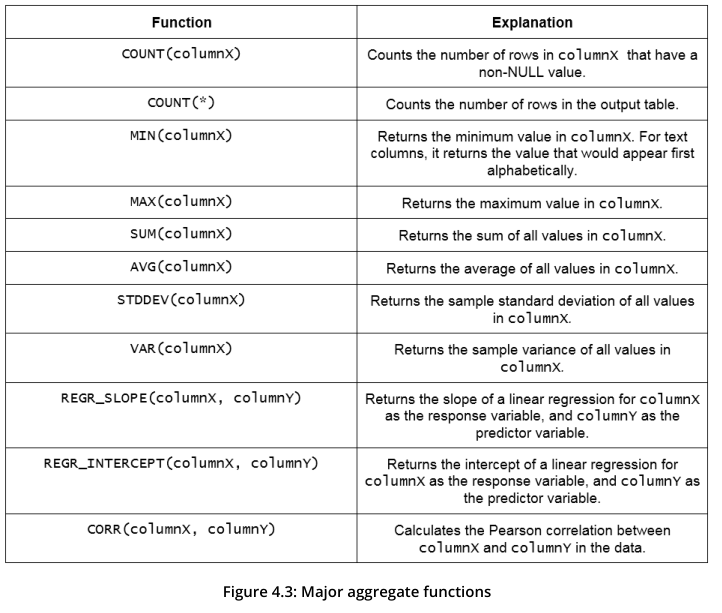

In [31]:
from IPython.display import Image
Image('images/aggregate_functions.PNG')

As funções agregadas também podem ser usadas com a cláusula **WHERE** para calcular valores agregados para subconjuntos de dados específicos. Por exemplo, se você quiser saber quantos clientes ZoomZoom tem na Califórnia, você pode usar a seguinte consulta:

In [32]:
sql = """
      SELECT COUNT(*)
      FROM customers
      WHERE state='CA';
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,count
0,5038


Você também pode fazer aritmética com funções agregadas. Na consulta a seguir, você pode dividir a contagem de linhas na tabela de clientes por dois, assim:

In [33]:
sql = """
      SELECT COUNT(*)/2
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,?column?
0,25000


Você também pode usar as funções agregadas entre si de maneiras matemáticas. Na consulta a seguir, em vez de usar a função AVG para calcular o MSRP médio de produtos no ZoomZoom, você pode "construir" a função AVG usando **SUM** e **COUNT** da seguinte forma:

In [34]:
sql = """
      SELECT SUM(base_msrp)::FLOAT/COUNT(*) AS avg_base_msrp
      FROM products
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,avg_base_msrp
0,35020.8275


> ##### Observação
> A razão pela qual temos que converter a soma é que o PostgreSQL trata a divisão inteira de forma diferente da divisão *float*. Por exemplo, dividir 7 por 2 como inteiros no PostgreSQL lhe dará 3. Para obter uma resposta mais precisa de 3.5, você tem que converter um dos números para *float*.

### Exercício 13: Usando Funções Agregadas para Analisar Dados
Aqui, analisaremos e calcularemos o preço de um produto usando diferentes funções agregadas. Como você está sempre curioso sobre os dados da sua empresa, está interessado em entender algumas das estatísticas básicas sobre os preços dos produtos ZoomZoom. Agora você quer calcular o preço mais baixo, o preço mais alto, o preço médio e o desvio padrão do preço para todos os produtos que a empresa já vendeu.

In [35]:
sql = """
      SELECT MIN(base_msrp), MAX(base_msrp), AVG(base_msrp), STDDEV(base_msrp)
      FROM products;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df

,min,max,avg,stddev
0,349.99,115000.0,35020.8275,47282.350266


## Funções agregadas com GROUP BY
Agora usamos funções agregadas para calcular estatísticas de uma coluna inteira. No entanto, muitas vezes, não estamos interessados nos valores agregados de uma tabela inteira, mas de grupos menores na tabela. Para ilustrar, voltemos à tabela dos **customers**. Sabemos que o número total de **customers** é de 50.000. Mas podemos querer saber quantos **customers** temos em cada estado. Como calcularíamos isso?

Podemos determinar quantos estados existem com a seguinte consulta:

In [36]:
sql = """
      SELECT DISTINCT state
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state
0,KS
1,None
2,CA
3,NH
4,OR


Depois de ter a lista de estados, você pode executar a seguinte consulta para cada estado, no caso abaixo "CA":

In [37]:
sql = """
      SELECT COUNT(*)
      FROM customers
      WHERE state='CA' 
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,count
0,5038


Embora você possa fazer isso, é incrivelmente tedioso e pode levar um tempo incrivelmente longo se houver muitos estados. Existe uma maneira melhor? Existe, e é através do uso da cláusula **GROUP BY**.
### GROUP BY
**GROUP BY** é uma cláusula que divide as linhas de um conjunto de dados em vários grupos com base em algum tipo de chave especificada na cláusula **GROUP BY**. Uma função agregada é então aplicada a todas as linhas dentro de um único grupo para produzir um único número. A chave **GROUP BY** e o valor agregado para o grupo são exibidos na saída SQL. O diagrama a seguir ilustra esse processo geral:

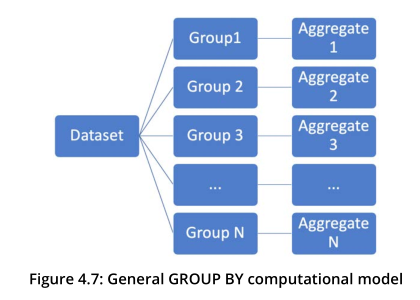

In [38]:
Image('images/GROUP_BY.PNG')

Na Figura 4.7, podemos ver que o conjunto de dados possui vários grupos (**Group 1, Group 2, ..., Group N**). Aqui, a função **Aggregate 1** é aplicada a todas as linhas do **Group1**, a função **Aggregate 2** é aplicada a todas as linhas do **Group 2** e assim por diante.

As instruções **GROUP BY** geralmente têm a seguinte estrutura:

`SELECT {KEY}, {AGGFUNC(column1)} FROM {table1} GROUP BY {KEY}`

Aqui, **{KEY}** é uma coluna ou função em uma coluna usada para criar grupos individuais, **{AGGFUNC(column1)}** é uma função agregada em uma coluna que é calculada para todas as linhas de cada grupo e **{table}** é a tabela ou conjunto de tabelas unidas das quais as linhas são separadas em grupos.

Para ilustrar melhor esse ponto, vamos contar o número de clientes em cada estado dos EUA usando uma consulta **GROUP BY**. Usando **GROUP BY**, um usuário SQL pode contar o número de clientes em cada estado consultando:

SELECT estado, COUNT(*) FROM clients GROUP BY estado 

In [39]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      GROUP BY state
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,count
0,KS,619
1,None,5467
2,CA,5038
3,NH,77
4,OR,386


O modelo computacional se parece com o seguinte:

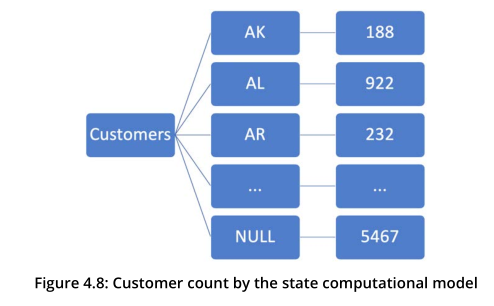

In [40]:
Image('images/customers_count.PNG')

Você também pode usar o número da coluna para realizar uma operação GROUP BY:

In [41]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      GROUP BY 1
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,count
0,KS,619
1,None,5467
2,CA,5038
3,NH,77
4,OR,386


Se você quiser retornar a saída em ordem alfabética, basta usar a seguinte consulta:

In [42]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      GROUP BY 1
      ORDER BY state
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,count
0,AK,188
1,AL,922
2,AR,232
3,AZ,931
4,CA,5038


Alternativamente, podemos escrever:

In [43]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      GROUP BY 1
      ORDER BY 1
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,count
0,AK,188
1,AL,922
2,AR,232
3,AZ,931
4,CA,5038


Muitas vezes, porém, você pode estar interessado em ordenar os próprios agregados. Os agregados podem ser encomendados usando ORDER BY da seguinte forma:

In [44]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      GROUP BY state
      ORDER BY COUNT(*)
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,count
0,VT,16
1,WY,23
2,ME,25
3,RI,47
4,NH,77


Você também pode contar apenas um subconjunto dos dados, como o número total de clientes do sexo masculino. Para calcular o número total de clientes do sexo masculino, você pode usar a seguinte consulta:

In [45]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      WHERE gender='M'
      GROUP BY state
      ORDER BY state
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,count
0,AK,87
1,AL,489
2,AR,120
3,AZ,415
4,CA,2572


### Várias colunas GROUP BY
Embora **GROUP BY** com uma coluna seja poderoso, você pode ir ainda mais longe e **GROUP BY** em várias colunas. Digamos que você queira obter uma contagem não apenas do número de clientes que o ZoomZoom tinha em cada estado, mas também de quantos clientes do sexo masculino e feminino ele tinha em cada estado. Várias colunas **GROUP BY** podem consultar a resposta da seguinte forma:

In [46]:
sql = """
      SELECT state, gender, COUNT(*)
      FROM customers
      GROUP BY state, gender
      ORDER BY state, gender
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,gender,count
0,AK,F,101
1,AK,M,87
2,AL,F,433
3,AL,M,489
4,AR,F,112


### Exercício 14: Calculando o Custo por Tipo de Produto Usando GROUP BY
Neste exercício, analisaremos e calcularemos o custo dos produtos usando funções agregadas e a cláusula **GROUP BY**. O gerente de marketing deseja saber o desvio mínimo, máximo, médio e padrão do preço de cada tipo de produto que o ZoomZoom vende, para uma campanha de marketing. Siga esses passos:

In [47]:
sql = """
      SELECT product_type, MIN(base_msrp), MAX(base_msrp), AVG(base_msrp),
      STDDEV(base_msrp)
      FROM products
      GROUP BY 1
      ORDER BY 1;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,product_type,min,max,avg,stddev
0,automobile,35000.00,115000.00,83240.000000,34140.617305
1,scooter,349.99,799.99,578.561429,167.971086


### Conjuntos de agrupamento
Agora, digamos que você queira contar o número total de clientes que você tem em cada estado, enquanto simultaneamente, nas mesmas funções agregadas, conta o número total de clientes do sexo masculino e feminino que você tem em cada estado. Como você poderia conseguir isso? Uma maneira é usar a palavra-chave **UNION ALL**, assim:

In [48]:
sql = """
      ( 
        SELECT state, NULL as gender, COUNT(*)
        FROM customers
        GROUP BY 1, 2
        ORDER BY 1, 2
        )
        
    UNION ALL
    (
        (
            SELECT state, gender, COUNT(*)
            FROM customers
            GROUP BY 1, 2
            ORDER BY 1, 2
            )
            )
        ORDER BY 1, 2
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,gender,count
0,AK,F,101
1,AK,M,87
2,AK,None,188
3,AL,F,433
4,AL,M,489


No entanto, usar **UNION ALL** é tedioso e pode ser muito difícil de escrever. Uma maneira alternativa é usar conjuntos de agrupamento. Os conjuntos de agrupamento permitem que um usuário crie várias categorias de visualização, semelhante à instrução **UNION ALL** que acabamos de ver. Por exemplo, usando a palavra-chave GROUPING SETS, você pode reescrever a consulta **UNION ALL** anterior como:

In [49]:
sql = """
      SELECT state, gender, COUNT(*)
      FROM customers
      
      GROUP BY GROUPING SETS (
        (state),
        (gender),
        (state, gender)
        )
      ORDER BY 1, 2
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,gender,count
0,AK,F,101
1,AK,M,87
2,AK,None,188
3,AL,F,433
4,AL,M,489


### Agregados de conjuntos ordenados
Até este ponto, todos os agregados que discutimos não dependiam da ordem dos dados. Usando **ORDER BY**, podemos ordenar os dados, mas não foi necessário. No entanto, há um subconjunto de estatísticas agregadas que dependem da ordem da coluna a ser calculada. Por exemplo, a mediana de uma coluna é algo que requer que a ordem dos dados seja especificada. Para calcular esses casos de uso, o SQL oferece uma série de funções chamadas funções de agregados de conjuntos ordenados. A figura a seguir lista as principais funções de agregação de conjuntos ordenados:

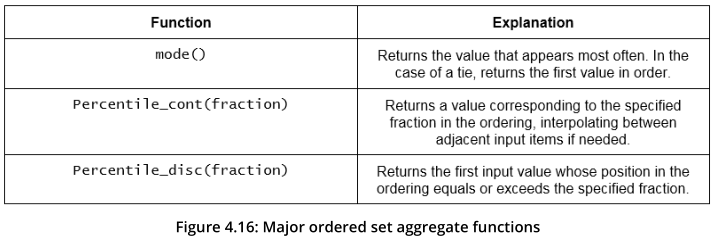

In [50]:
Image('images/ordered_functions.PNG')

As funções são usadas com o seguinte formato:

`SELECT {ordered_set_function}`

`WITHIN GROUP (ORDER BY {order_column})`

`FROM {table};`

Em que **{ordered_set_function}** é a função agregada do conjunto ordenado, **{order_column}** é a coluna para ordenar os resultados da função e **{table}** é a tabela na qual a coluna está.

Para ilustrar, digamos que você queira calcular o preço médio da tabela de produtos. Você pode usar a seguinte consulta:

In [51]:
sql = """
      SELECT PERCENTILE_CONT(0.5)
      WITHIN GROUP (ORDER BY base_msrp) AS median
      FROM products;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,median
0,749.99


A razão pela qual usamos **0.5** é porque a mediana é o 50th percentil, que é **0,5** como uma fração. Isso deu o resultado acima.

Com funções agregadas de conjuntos ordenados, agora temos ferramentas para calcular praticamente qualquer estatística agregada de interesse para um conjunto de dados. Na próxima seção, veremos como usar agregações para lidar com a qualidade dos dados.

### A Cláusula HAVING
Agora podemos realizar todos os tipos de operações agregadas usando **GROUP BY**. Às vezes, porém, certas linhas em funções agregadas podem não ser úteis e você pode removê-las da saída da consulta. Por exemplo, ao fazer a contagem de clientes, talvez você esteja interessado apenas em lugares que tenham pelo menos **1.000 clientes**. Seu primeiro instinto pode ser escrever algo como isto:

`SELECT state, COUNT(*)`

`FROM customers`

`WHERE COUNT(*)>=1,000`

`GROUP BY state`

`ORDER BY state`

No entanto, você descobrirá que a consulta não funciona e apresenta o seguinte erro:

In [52]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      WHERE COUNT(*)>=1,000
      GROUP BY state
      ORDER BY state
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

DatabaseError: Execution failed on sql '
      SELECT state, COUNT(*)
      FROM customers
      WHERE COUNT(*)>=1,000
      GROUP BY state
      ORDER BY state
      ': syntax error at or near ","
LINE 4:       WHERE COUNT(*)>=1,000
                               ^


Para usar o filtro em funções agregadas, você precisa usar uma nova cláusula, **HAVING**. A cláusula **HAVING** é semelhante à cláusula **WHERE**, exceto que é projetada especificamente para consultas **GROUP BY**. A estrutura geral de uma operação **GROUP BY** com uma instrução **HAVING** é:

`SELECT {KEY}, {AGGFUNC(column1)}`

`FROM {table1}`

`GROUP BY {KEY}`

`HAVING {OTHER_AGGFUNC(column2)_CONDITION}`

Aqui, **{KEY}** é uma coluna ou função em uma coluna que é usada para criar grupos individuais, **{AGGFUNC(column1)}** é uma função agregada em uma coluna que é calculada para todas as linhas dentro de cada grupo, **{table}** é a tabela ou conjunto de tabelas unidas das quais as linhas são separadas em grupos, e **{OTHER_AGGFUNC(column2)_CONDITION}** é uma condição semelhante à que você colocaria em uma cláusula **WHERE** envolvendo uma função de agregação.

### Exercício 15: Calculando e Exibindo Dados Usando a Cláusula HAVING
Neste exercício, vamos calcular e exibir dados usando a cláusula **HAVING**. O gerente de vendas do ZoomZoom quer saber a contagem de clientes para os estados que possuem pelo menos 1.000 clientes que compraram algum produto do ZoomZoom. Ajude o gerente a extrair os dados.

In [57]:
sql = """
      SELECT state, COUNT(*)
      FROM customers
      GROUP BY state
      HAVING COUNT(*)>=1.000
      ORDER BY state
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,count
0,AK,188
1,AL,922
2,AR,232
3,AZ,931
4,CA,5038


Podemos ver os estados que possuem mais de 1.000 clientes ZoomZoom, sendo CA com **5038**, o maior número de clientes, e CO com **1042**, o menor número de clientes.

## Usando agregados para limpar dados e examinar a qualidade dos dados
Discutimos anteriomente como o SQL pode ser usado para limpar dados. Embora as técnicas passadas façam um excelente trabalho de limpeza de dados, as agregações adicionam várias técnicas que podem tornar a limpeza de dados ainda mais fácil e abrangente. Nesta seção, veremos algumas dessas técnicas.
### Encontrando valores ausentes com GROUP BY
Conforme mencionado, anteriormente, um dos maiores problemas com a limpeza de dados é lidar com valores ausentes. Discutimos como encontrar valores ausentes e como podemos nos livrar deles, não falamos muito sobre como podemos determinar a extensão dos dados ausentes em um conjunto de dados. Principalmente porque não tínhamos as ferramentas para lidar com o resumo de informações em um conjunto de dados – isto é, até este módulo.

Usando agregações, identificar a quantidade de dados ausentes pode informar não apenas quais colunas têm dados ausentes, mas também se as colunas são utilizáveis porque muitos dos dados estão ausentes. Dependendo da extensão dos dados ausentes, você terá que determinar se faz mais sentido excluir linhas com dados ausentes, preencher valores ausentes ou apenas excluir colunas, pois elas não possuem dados suficientes para tirar conclusões definitivas.

A maneira mais fácil de determinar se uma coluna está com valores ausentes é usar uma instrução **CASE WHEN** modificada com as funções **SUM** e **COUNT** para determinar qual porcentagem de dados está ausente. De um modo geral, a consulta tem a seguinte aparência:

`SELECT SUM(CASE WHEN {column1} IS NULL OR {column1} IN ({missing_values})`

`THEN 1 ELSE 0 END)::FLOAT/COUNT(*)`

`FROM {table1}`

Aqui, **{column1}** é a coluna que você deseja verificar quanto a valores ausentes, **{missing_ values}** é uma lista separada por vírgulas de valores considerados ausentes e **{table1}** é a tabela ou subconsulta com os valores ausentes.

Com base nos resultados dessa consulta, talvez seja necessário variar sua estratégia para lidar com dados ausentes. Se uma porcentagem muito pequena de seus dados estiver ausente (<1%), considere apenas filtrar ou excluir os dados ausentes de sua análise. Se alguns de seus dados estiverem faltando (<20%), você pode considerar preencher os dados faltantes com um valor típico, como a média ou a moda, para realizar uma análise precisa. Se, no entanto, mais de 20% de seus dados estiverem ausentes, talvez seja necessário remover a coluna de sua análise de dados, pois não haveria dados precisos suficientes para tirar conclusões precisas com base nos valores da coluna.

Vejamos os dados ausentes na tabela de clientes. Especificamente, vamos analisar os dados ausentes na coluna **street_address** com a seguinte consulta:

In [58]:
sql = """
      SELECT SUM(CASE WHEN state IS NULL OR state IN ('') THEN 1
      ELSE 0 END)::FLOAT/COUNT(*)
      AS missing_state
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,missing_state
0,0.10934


Como visto aqui, falta um pouco menos de 11% dos dados estaduais. Para fins de análise, convém considerar que esses clientes são da CA, pois CA é o estado mais comum nos dados. No entanto, a coisa muito mais precisa a fazer seria encontrar e preencher os dados ausentes.
### Medindo a qualidade dos dados com agregados
Um dos principais temas que você encontrará na análise de dados é que a análise é fundamentalmente útil apenas quando há uma forte variação nos dados. Uma coluna em que todos os valores são exatamente iguais não é uma coluna particularmente útil. Para esse fim, geralmente faz sentido determinar quantos valores distintos existem em uma coluna. Para medir o número de valores distintos em uma coluna, podemos usar a função **COUNT DISTINCT** para descobrir quantos valores distintos existem. A estrutura de tal consulta ficaria assim:

`SELECT COUNT (DISTINCT {column1})`

`FROM {table1}`

In [53]:
sql = """
      SELECT COUNT (DISTINCT customer_id)=COUNT(*) AS equal_ids
      FROM customers;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,equal_ids
0,True


### Atividade 6: Analisando Dados de Vendas Usando Funções Agregadas
O objetivo desta atividade é analisar dados usando funções agregadas. O CEO, COO e CFO da ZoomZoom gostaria de obter alguns insights sobre o que pode estar impulsionando as vendas. Agora que a empresa sente que tem uma equipe de análise forte o suficiente com sua chegada. A tarefa foi dada a você e seu chefe informou educadamente que este projeto é o projeto mais importante em que a equipe de análise trabalhou:
1. Abra seu cliente SQL favorito e conecte-se ao banco de dados *sqlda*.
2. Calcule o número total de vendas unitárias que a empresa realizou.
3. Calcule o valor total das vendas em dólares para cada estado.
4. Identifique as cinco melhores concessionárias em termos de mais unidades vendidas (ignore as vendas pela internet).
5. Calcule o valor médio de vendas para cada canal, conforme visto na tabela de vendas, e observe o valor médio de vendas primeiro por vendas de canal, depois por product_id e depois por ambos juntos.

In [79]:
sql = """
      SELECT COUNT (*)
      FROM sales;
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,count
0,37711


In [81]:
sql = """
      SELECT state, SUM(s.sales_amount) TOTAL
      FROM sales AS s
      INNER JOIN customers AS c
            ON s.customer_id = c.customer_id
      GROUP BY state
      ORDER BY state
      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,state,total
0,AK,1.124269e+06
1,AL,4.820334e+06
2,AR,1.487924e+06
3,AZ,4.109364e+06
4,CA,2.794272e+07


In [83]:
sql = """
      SELECT s.dealership_id, COUNT(*)
      FROM sales AS s
      WHERE channel ='dealership'
      GROUP BY dealership_id
      ORDER BY count DESC
      LIMIT 5


      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,dealership_id,count
0,10.0,1781
1,7.0,1583
2,18.0,1465
3,11.0,1312
4,1.0,1297


In [78]:
sql = """
      SELECT s.channel, s.product_id, AVG(s.sales_amount) Average
      FROM sales AS s
      JOIN dealerships AS d
            ON d.dealership_id = s.dealership_id
      GROUP BY s.channel, s.product_id
      ORDER BY s.channel, s.product_id

      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,channel,product_id,average
0,dealership,3,477.253738
1,dealership,4,109822.274882
2,dealership,5,664.330132
3,dealership,6,62563.376384
4,dealership,7,573.744147


In [86]:
sql = """
      SELECT s.channel, s.product_id, AVG(sales_amount) as avg_sales_amount
      FROM sales s
      GROUP BY
            GROUPING SETS(
                  (s.channel), (s.product_id),
                  (s.channel, s.product_id)
                        )
      ORDER BY 1, 2

      """
df = pd.read_sql_query(con=connection, sql=sql)
df.head()

,channel,product_id,avg_sales_amount
0,dealership,3.0,477.253738
1,dealership,4.0,109822.274882
2,dealership,5.0,664.330132
3,dealership,6.0,62563.376384
4,dealership,7.0,573.744147
